<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Define-Functions" data-toc-modified-id="Define-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Functions</a></span><ul class="toc-item"><li><span><a href="#Melt" data-toc-modified-id="Melt-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Melt</a></span></li><li><span><a href="#Stationarity-Check" data-toc-modified-id="Stationarity-Check-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Stationarity Check</a></span></li></ul></li><li><span><a href="#Calculate-RMSE-for-top-zip-codes-by-percent-increase" data-toc-modified-id="Calculate-RMSE-for-top-zip-codes-by-percent-increase-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate RMSE for top zip codes by percent increase</a></span><ul class="toc-item"><li><span><a href="#Create-Melted-Dataframe-of-ZipCodes" data-toc-modified-id="Create-Melted-Dataframe-of-ZipCodes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create Melted Dataframe of ZipCodes</a></span></li><li><span><a href="#Print-Decomposition-Chart-for-each-Zip-Code" data-toc-modified-id="Print-Decomposition-Chart-for-each-Zip-Code-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Print Decomposition Chart for each Zip Code</a></span></li><li><span><a href="#Seasonality-Trends-Fascinating" data-toc-modified-id="Seasonality-Trends-Fascinating-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Seasonality Trends Fascinating</a></span></li></ul></li><li><span><a href="#Stationarity-Check-for-each-zip-code" data-toc-modified-id="Stationarity-Check-for-each-zip-code-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stationarity Check for each zip code</a></span></li><li><span><a href="#GridSearch-for-SARIMA-Parameters" data-toc-modified-id="GridSearch-for-SARIMA-Parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>GridSearch for SARIMA Parameters</a></span><ul class="toc-item"><li><span><a href="#Calculate-optimal-parameters,-Model,-Predict,-calculate-RMSE" data-toc-modified-id="Calculate-optimal-parameters,-Model,-Predict,-calculate-RMSE-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Calculate optimal parameters, Model, Predict, calculate RMSE</a></span></li></ul></li><li><span><a href="#Determine-Price-Forecast" data-toc-modified-id="Determine-Price-Forecast-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Determine Price Forecast</a></span></li></ul></div>

# Import Libraries

In [18]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.seasonal import seasonal_decompose

# Define Functions

## Melt 

In [19]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode','SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

## Stationarity Check 

In [20]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# Calculate RMSE for top zip codes by percent increase

## Create Melted Dataframe of ZipCodes 

In [21]:
# Create dataframe from zillow median home price data
df = pd.read_csv('zillow_data.csv')

# make copy of df
df1 = df.copy()

# Rename RegionName as ZipCode
df1 = df1.rename(columns={"RegionName": "ZipCode"})

# add column with percent change between 2017 and 1996 average value
df1['Percent Change'] = (df['2018-04'] / df['2012-04']) * 100

# create new dataframe with top 10 zip codes for Percent Change
df_percent = df1.sort_values('Percent Change',ascending = False)

# new df_percent with only top ten results
df_percent = df_percent.head(15)

# Remove Raw Difference and Percent Change for melting
prospects = df_percent.drop(columns=['Percent Change', 'RegionID'])

# Remove Column with missing data
prospects = prospects.drop([1946])

In [22]:
prospects.head(15)

ZipCode              City State                  Metro    CountyName  \
1477    94601           Oakland    CA          San Francisco       Alameda   
1239    94590           Vallejo    CA                Vallejo        Solano   
2627    33460        Lake Worth    FL  Miami-Fort Lauderdale    Palm Beach   
1681    94606           Oakland    CA          San Francisco       Alameda   
1853    94804          Richmond    CA          San Francisco  Contra Costa   
1960    89104         Las Vegas    NV              Las Vegas         Clark   
474     85008           Phoenix    AZ                Phoenix      Maricopa   
4298    95824        Sacramento    CA             Sacramento    Sacramento   
2409    33404     Riviera Beach    FL  Miami-Fort Lauderdale    Palm Beach   
2661    33705  Saint Petersburg    FL                  Tampa      Pinellas   
2934    89107         Las Vegas    NV              Las Vegas         Clark   
815     89115         Las Vegas    NV              Las Vegas         Clark   
2775    95820        Sacramento    CA             Sacramento    Sacramento   
5830    48240           Redford    MI                Detroit         Wayne   

      SizeRank   1996-04   1996-05   1996-06   1996-07  ...  2017-07  2017-08  \
1477      1478  114600.0  114500.0  114500.0  114400.0  ...   501300   506600   
1239      1240  108200.0  107800.0  107500.0  107300.0  ...   335100   339600   
2627      2628   59800.0   59900.0   60000.0   60200.0  ...   191300   195500   
1681      1682  120400.0  120300.0  120300.0  120200.0  ...   599200   611000   
1853      1854  171300.0  170300.0  169400.0  168500.0  ...   430400   434100   
1960      1961   94800.0   94700.0   94700.0   94700.0  ...   178700   181500   
474        475   61600.0   61900.0   62200.0   62600.0  ...   201400   204200   
4298      4299   73800.0   73400.0   73000.0   72600.0  ...   210300   211700   
2409      2410   56800.0   56700.0   56600.0   56500.0  ...   121200   122800   
2661      2662   54600.0   54800.0   55000.0   55200.0  ...   150500   154700   
2934      2935   92300.0   92400.0   92500.0   92600.0  ...   170200   172500   
815        816   92500.0   92500.0   92600.0   92600.0  ...   156100   158200   
2775      2776   71800.0   71800.0   71800.0   71700.0  ...   253800   254000   
5830      5831   67800.0   68200.0   68500.0   68800.0  ...    65900    67100   

      2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
1477   514100   521100   526700   535800   546900   555000   562000   566700  
1239   343500   346700   351200   357100   362500   366900   371600   376100  
2627   198400   200400   202600   206000   209600   211600   213300   215600  
1681   622300   632800   646100   663100   676500   683700   691700   696800  
1853   438900   441700   443900   448000   452400   459200   471800   483100  
1960   184600   188500   192500   196300   199500   202500   206000   208500  
474    206700   209200   210200   210300   211300   213900   218800   223000  
4298   213300   214500   215900   218400   221400   223500   224700   224700  
2409   124600   125900   126900   128500   129900   130700   132300   134700  
2661   158900   162500   165300   167100   168200   171100   175100   177300  
2934   175000   178000   180700   184000   187000   190000   193500   196200  
815    160900   164000   166300   168200   170400   172700   174700   176000  
2775   254200   255000   256000   258000   260600   262300   263200   263200  
5830    68100    68700    69700    71000    72300    73500    75300    76800  

[14 rows x 271 columns]

In [23]:
# Check for missing data
print(prospects.isnull().sum().sum())

0


## Print Decomposition Chart for each Zip Code

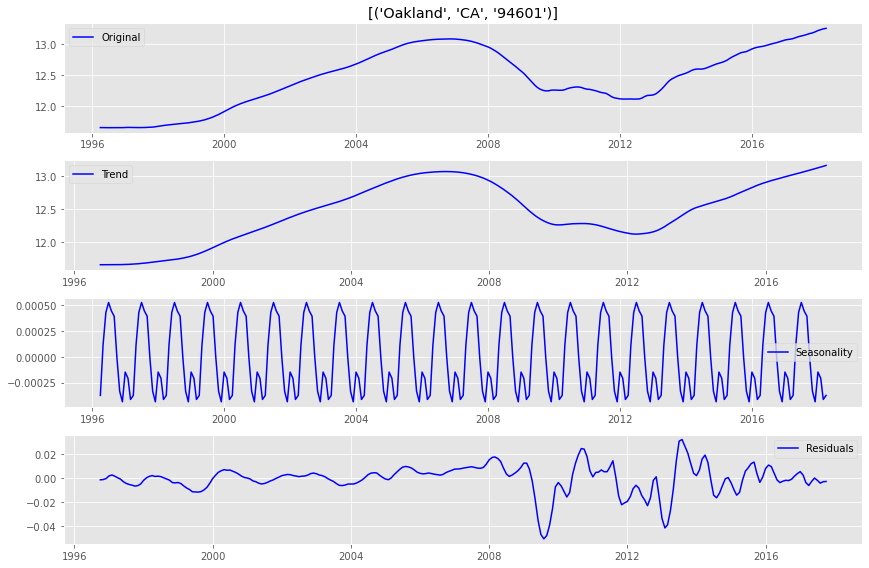

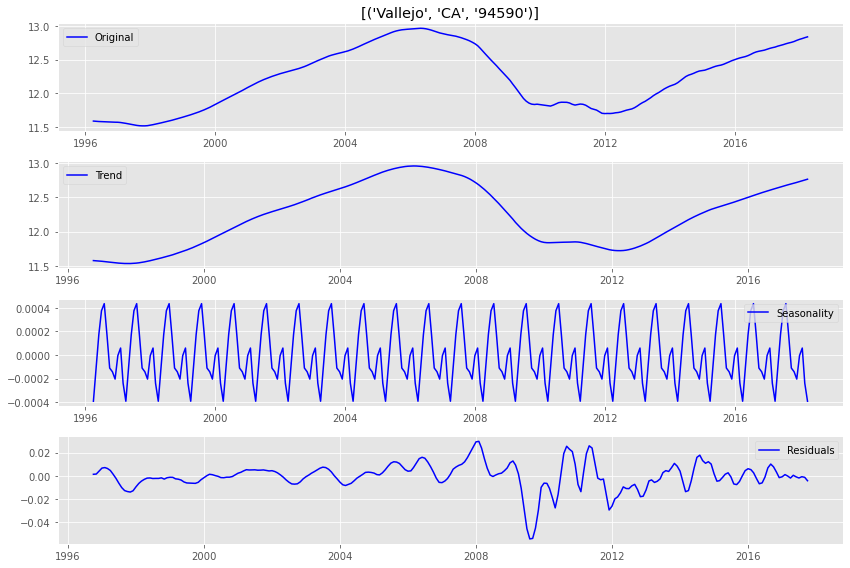

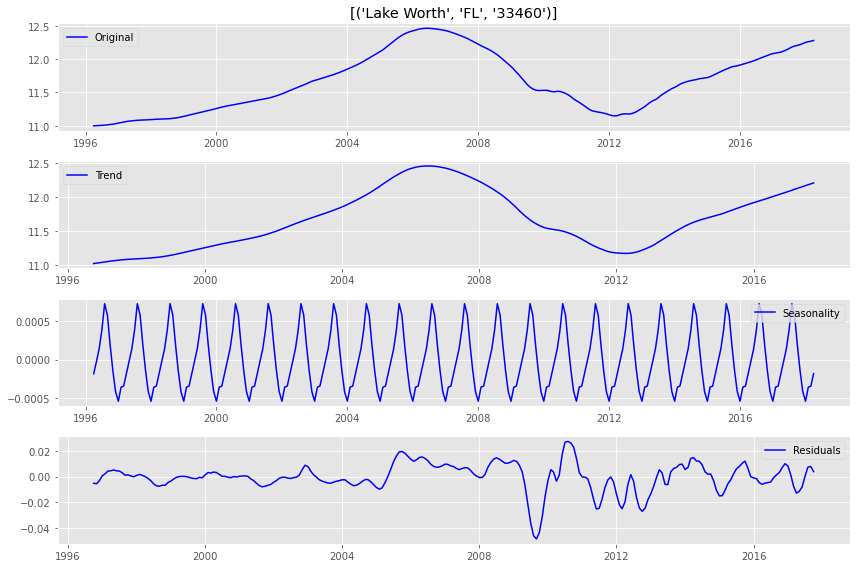

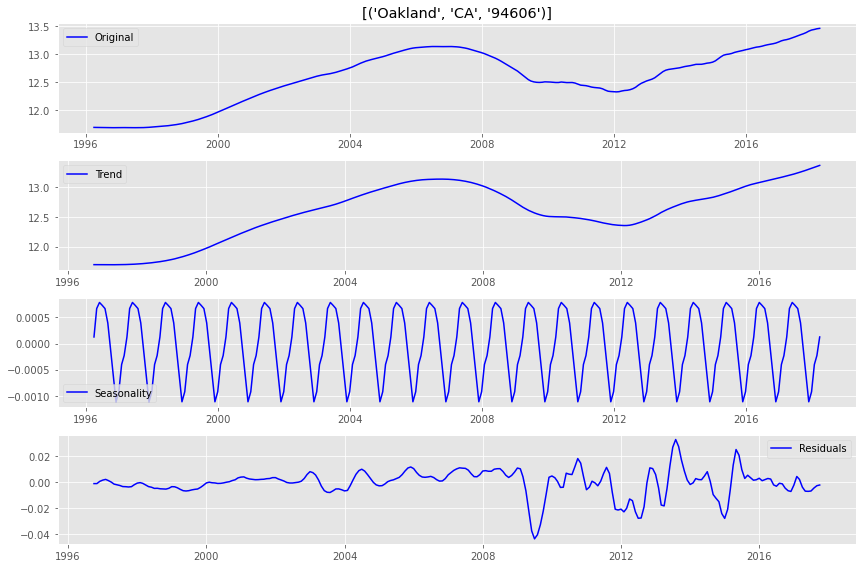

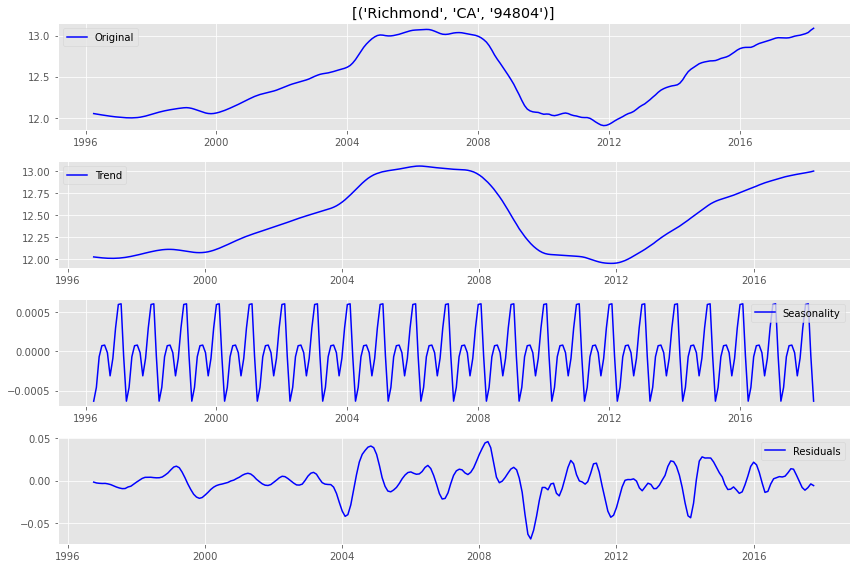

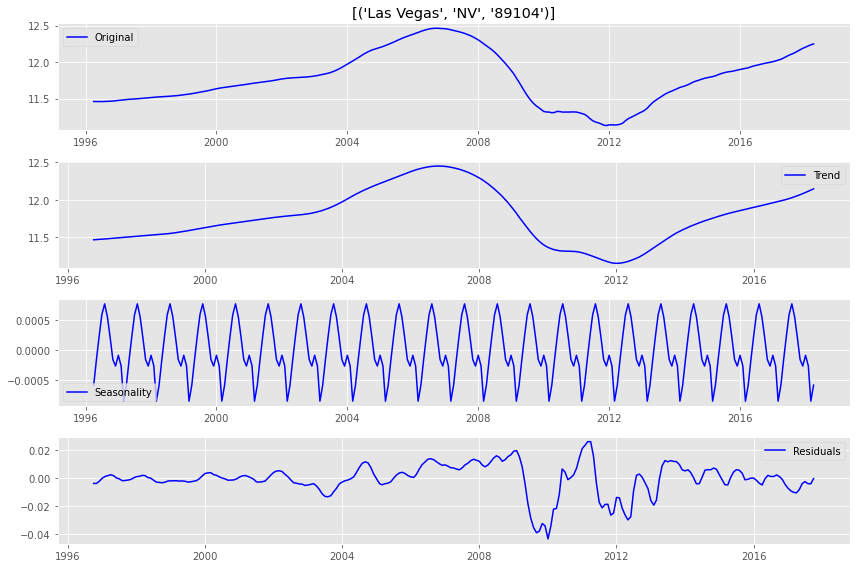

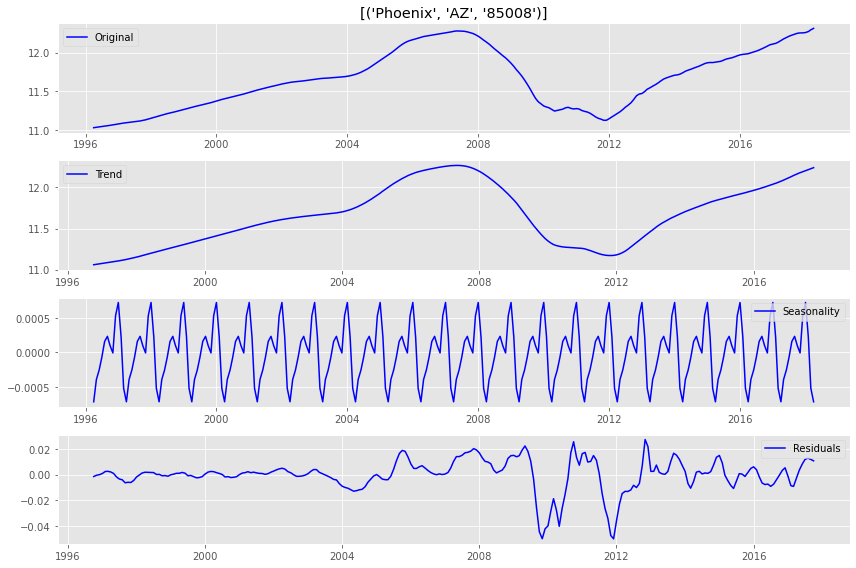

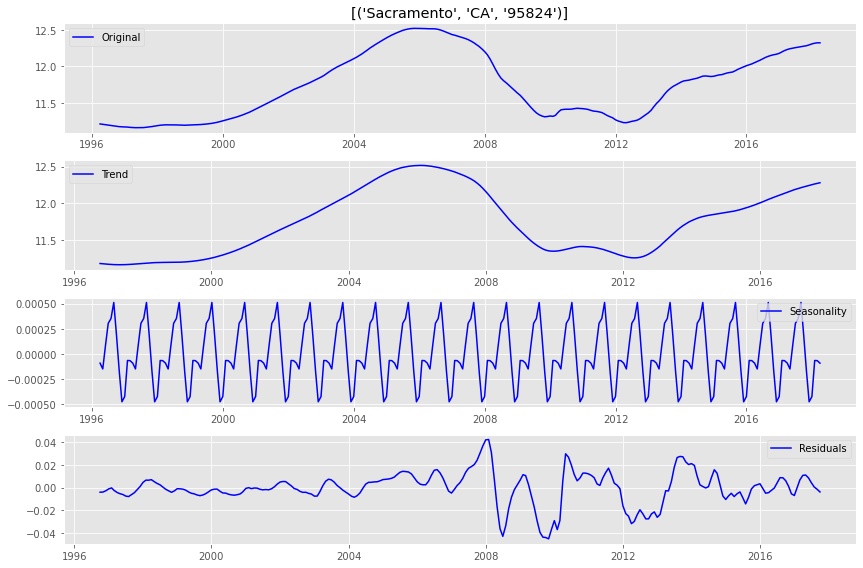

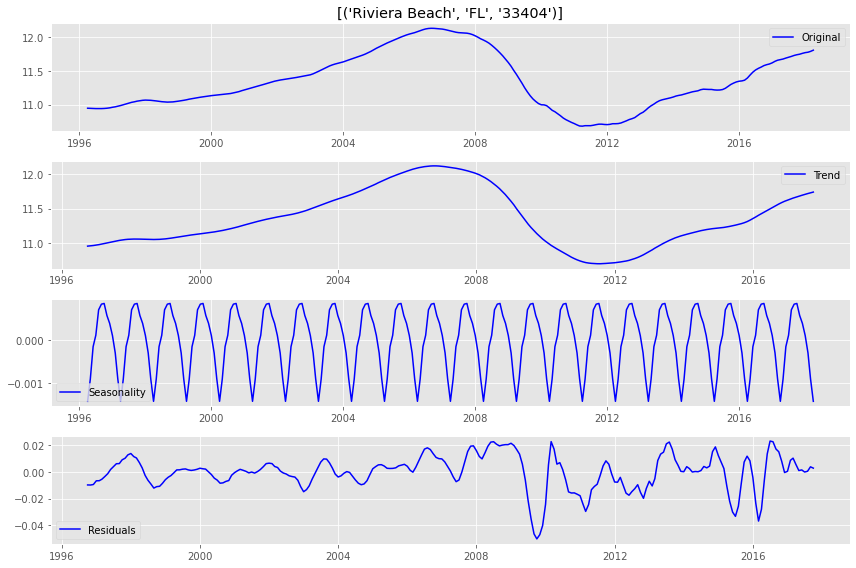

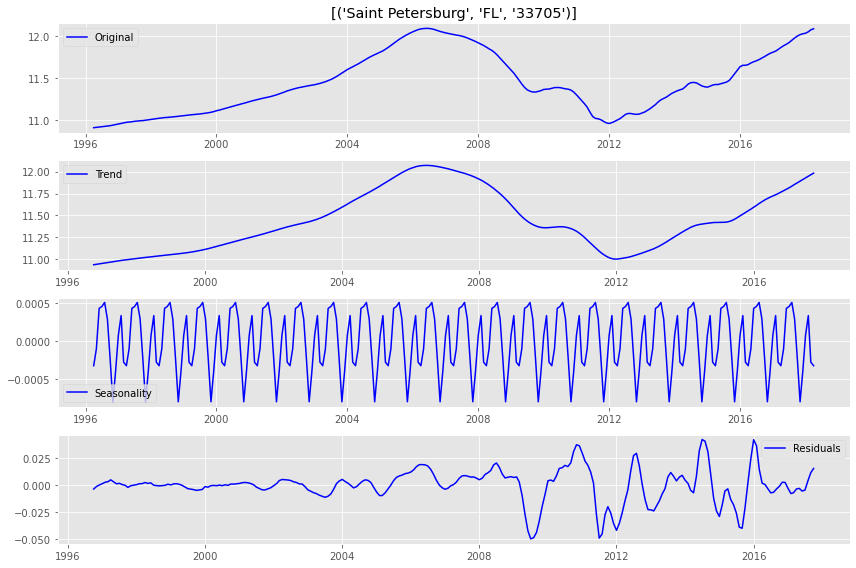

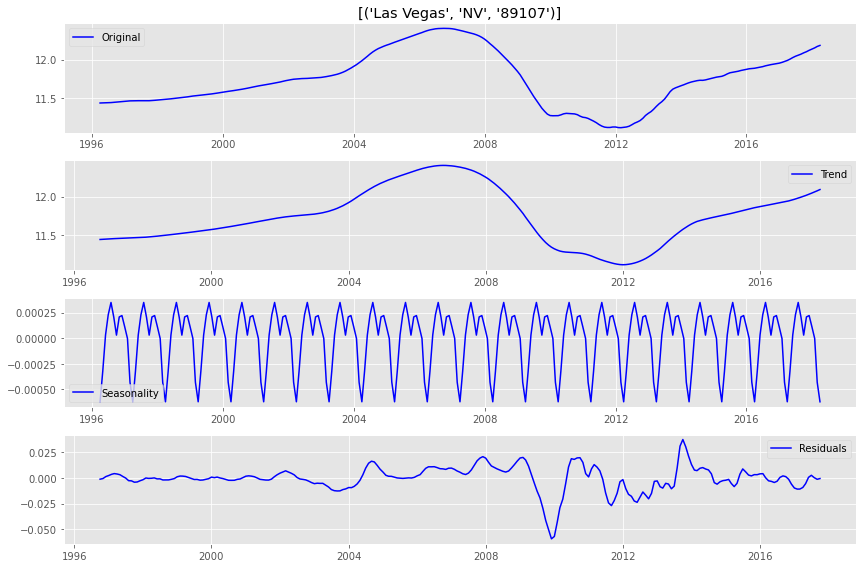

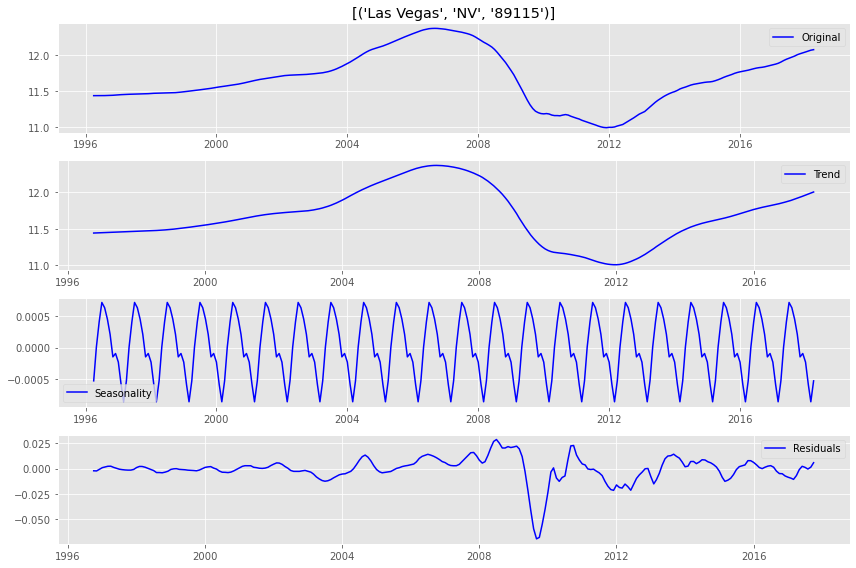

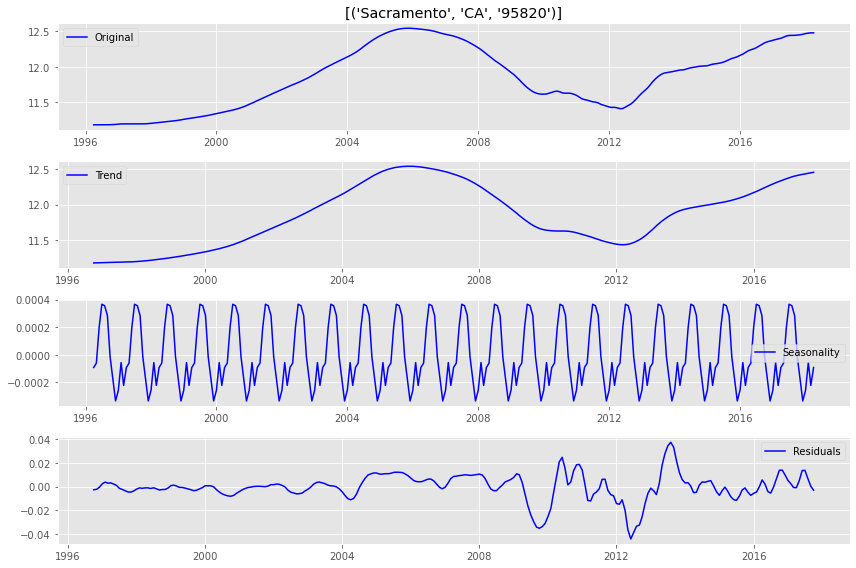

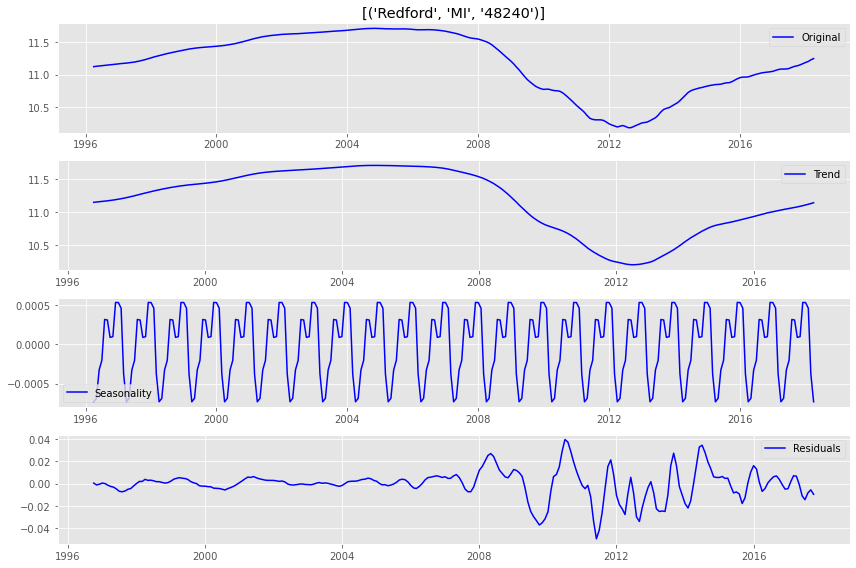

In [24]:
# Melt and decompose each zip from prospects df
for zipcode in prospects['ZipCode']:
    zips = prospects.loc[prospects['ZipCode'] == zipcode]
    m1 = melt_data(zips)
    m1[zips.iloc[0,1],zips.iloc[0,2],str(zipcode)] = m1['value']
    m1 = m1.drop('value', axis=1)
    
    #Apply seasonal_decompose()
    decomposition = seasonal_decompose(np.log(m1))

    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.title(str(m1.columns.values))
    plt.plot(np.log(m1), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

## Seasonality Trends Fascinating
* Seasonality present in every zip code, but how the trend occurs is different for each zip code.

# Stationarity Check for each zip code

[('Oakland', 'CA', '94601')]


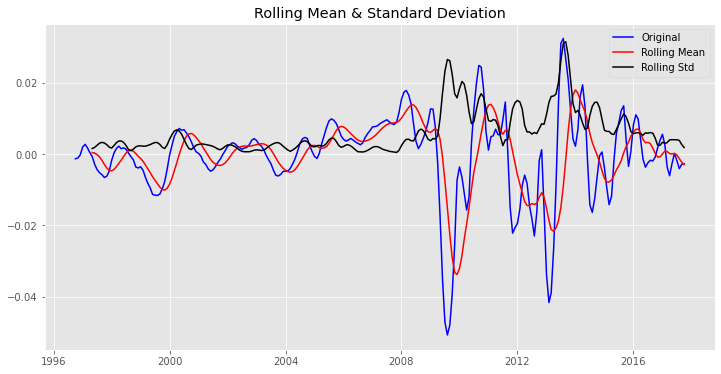

Results of Dickey-Fuller Test: 

Test Statistic                  -4.457975
p-value                          0.000234
#Lags Used                      14.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64
None


[('Vallejo', 'CA', '94590')]


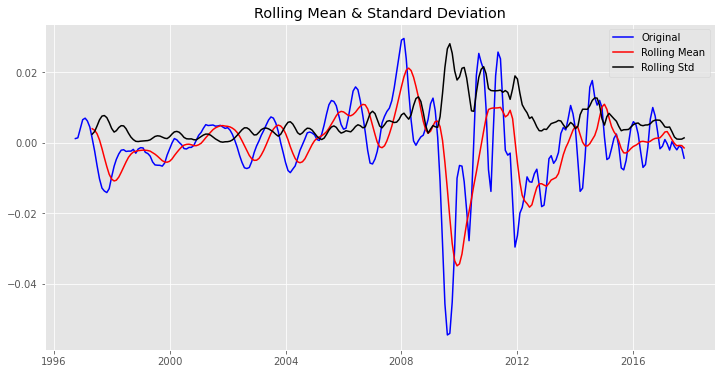

Results of Dickey-Fuller Test: 

Test Statistic                  -4.202953
p-value                          0.000651
#Lags Used                      13.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64
None


[('Lake Worth', 'FL', '33460')]


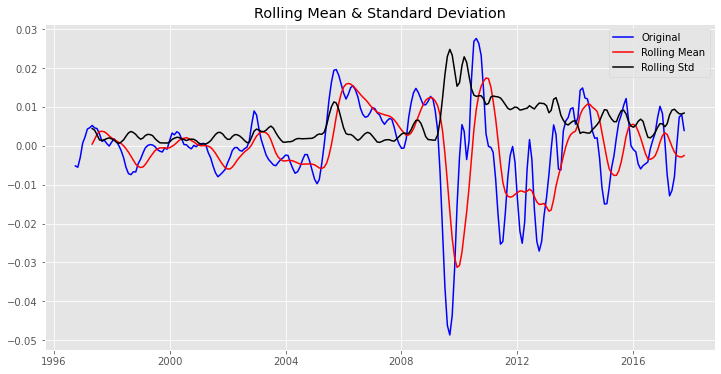

Results of Dickey-Fuller Test: 

Test Statistic                -5.934915e+00
p-value                        2.333228e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
None


[('Oakland', 'CA', '94606')]


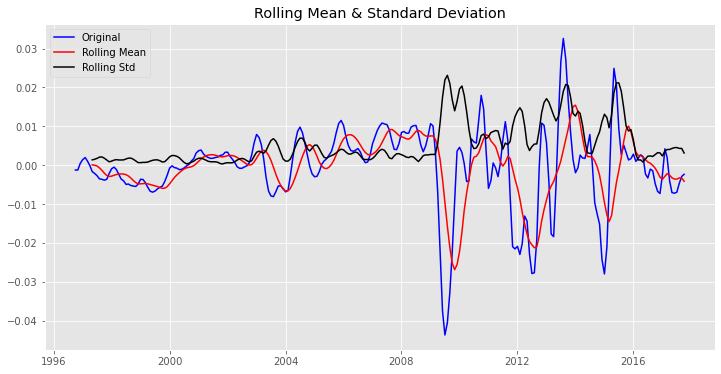

Results of Dickey-Fuller Test: 

Test Statistic                  -4.361429
p-value                          0.000347
#Lags Used                      14.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64
None


[('Richmond', 'CA', '94804')]


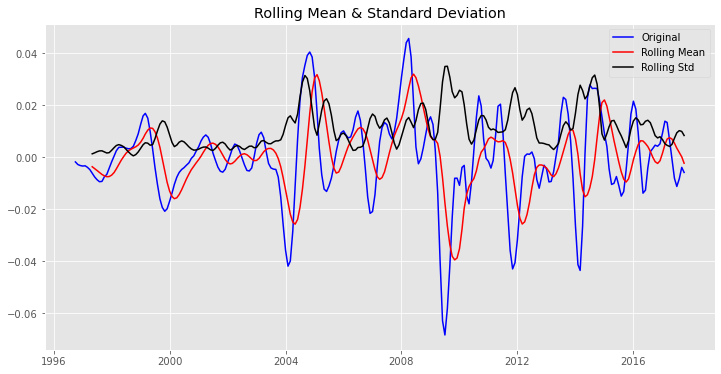

Results of Dickey-Fuller Test: 

Test Statistic                  -5.476416
p-value                          0.000002
#Lags Used                       8.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64
None


[('Las Vegas', 'NV', '89104')]


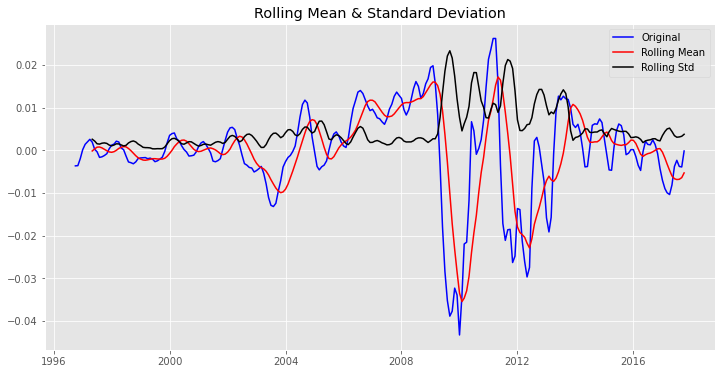

Results of Dickey-Fuller Test: 

Test Statistic                  -3.641962
p-value                          0.005008
#Lags Used                      16.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64
None


[('Phoenix', 'AZ', '85008')]


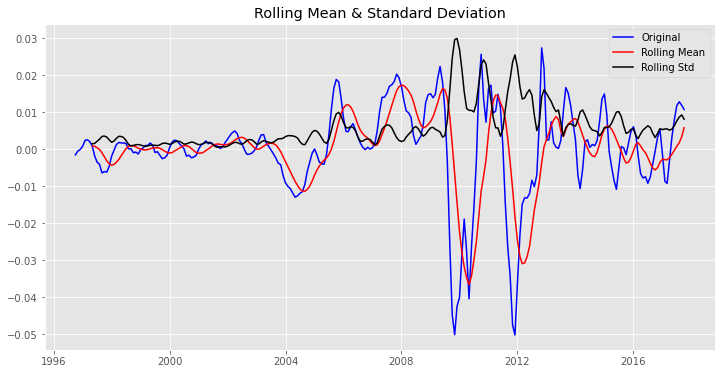

Results of Dickey-Fuller Test: 

Test Statistic                  -3.176072
p-value                          0.021412
#Lags Used                      14.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64
None


[('Sacramento', 'CA', '95824')]


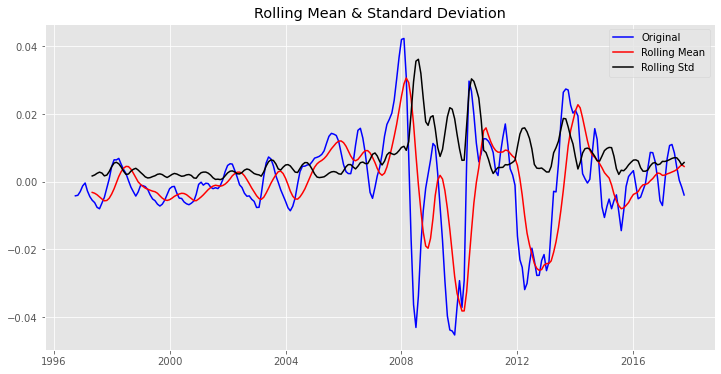

Results of Dickey-Fuller Test: 

Test Statistic                  -4.633011
p-value                          0.000112
#Lags Used                      15.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64
None


[('Riviera Beach', 'FL', '33404')]


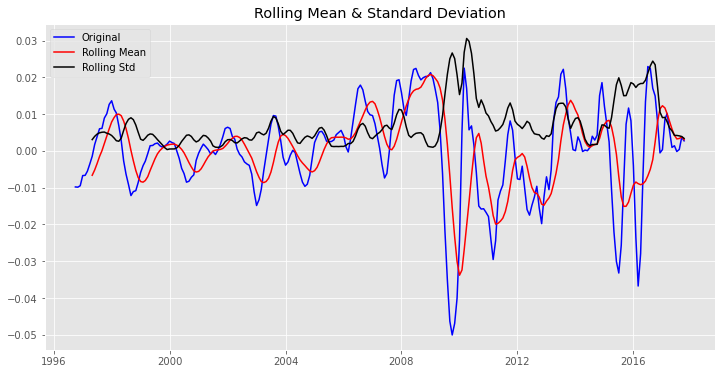

Results of Dickey-Fuller Test: 

Test Statistic                  -3.820125
p-value                          0.002708
#Lags Used                      10.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
None


[('Saint Petersburg', 'FL', '33705')]


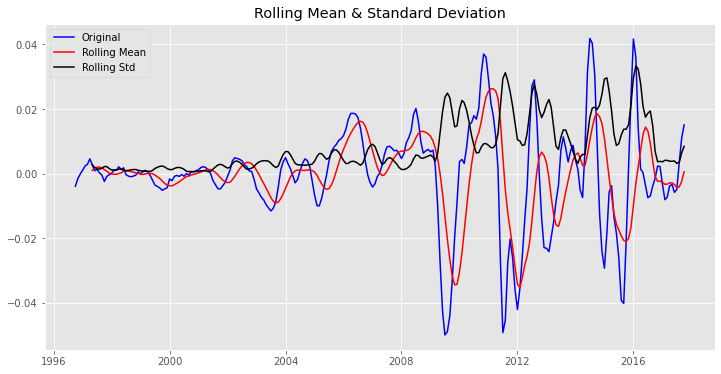

Results of Dickey-Fuller Test: 

Test Statistic                -6.023361e+00
p-value                        1.475617e-07
#Lags Used                     1.000000e+01
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
None


[('Las Vegas', 'NV', '89107')]


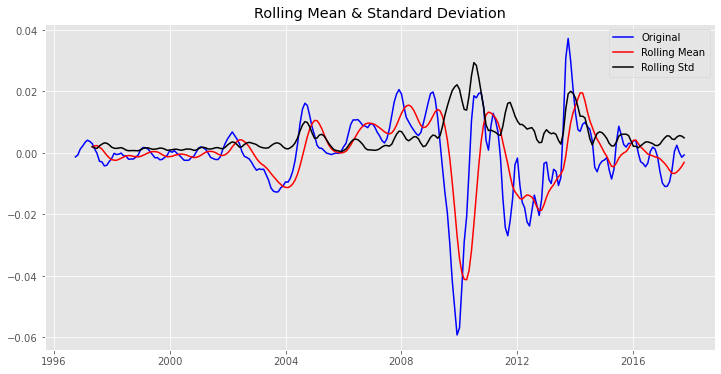

Results of Dickey-Fuller Test: 

Test Statistic                  -5.264941
p-value                          0.000006
#Lags Used                       6.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64
None


[('Las Vegas', 'NV', '89115')]


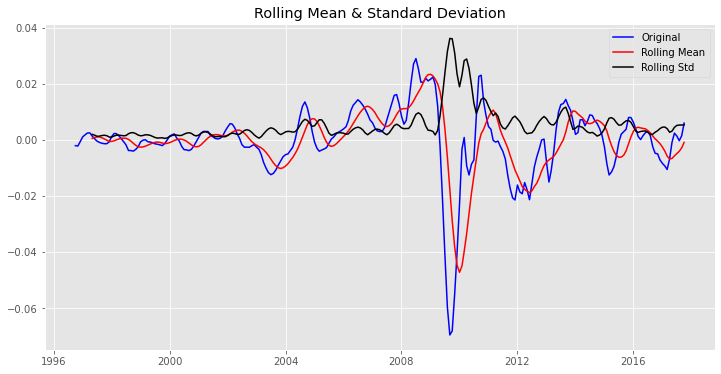

Results of Dickey-Fuller Test: 

Test Statistic                  -3.604256
p-value                          0.005680
#Lags Used                      16.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64
None


[('Sacramento', 'CA', '95820')]


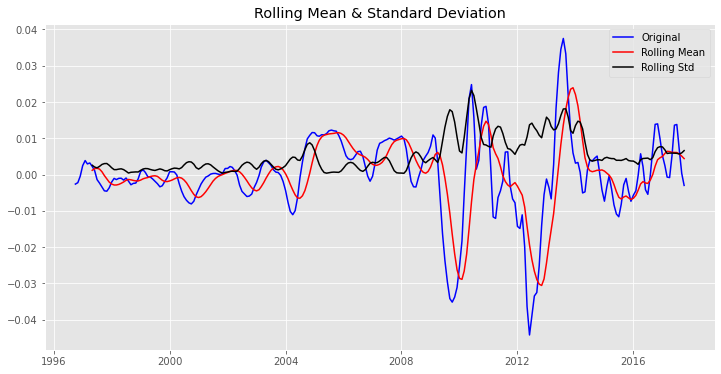

Results of Dickey-Fuller Test: 

Test Statistic                  -4.435702
p-value                          0.000257
#Lags Used                      13.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64
None


[('Redford', 'MI', '48240')]


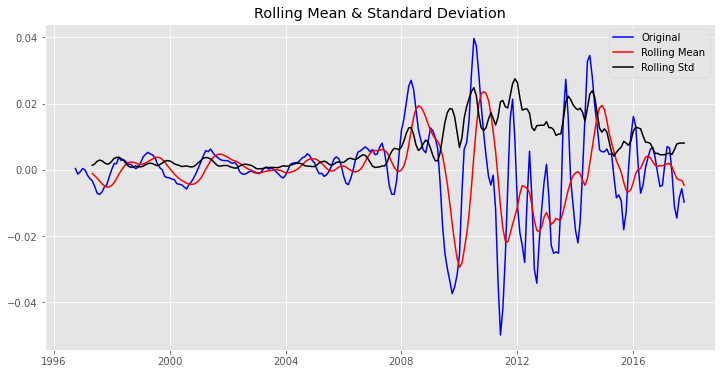

Results of Dickey-Fuller Test: 

Test Statistic                  -3.048644
p-value                          0.030595
#Lags Used                      16.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64
None




In [25]:
for zipcode in prospects['ZipCode']:
    zips = prospects.loc[prospects['ZipCode'] == zipcode]
    m1 = melt_data(zips)
    m1[zips.iloc[0,1],zips.iloc[0,2],str(zipcode)] = m1['value']
    m1 = m1.drop('value', axis=1)
    
    #Apply seasonal_decompose()
    decomposition = seasonal_decompose(np.log(m1))

    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Drop missing values from residuals 
    percent1_log_decompose = residual
    percent1_log_decompose.dropna(inplace=True)
    
    # Print Zip Code Name and Check stationarity
    print(str(m1.columns.values))
    print(stationarity_check(percent1_log_decompose))
    print()
    print()

# GridSearch for SARIMA Parameters

In [26]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [27]:
pdqs

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

## Calculate optimal parameters, Model, Predict, calculate RMSE 
* Run for all zip codes in prospects

['94601']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9596      0.022     44.037      0.000       0.917       1.002
ma.L1          0.3172      0.024     13.207      0.000       0.270       0.364
ar.S.L12      -0.6059      0.067     -9.009      0.000      -0.738      -0.474
ma.S.L12      -0.0231      0.044     -0.520      0.603      -0.110       0.064
sigma2      1.631e+06   1.27e+05     12.846      0.000    1.38e+06    1.88e+06


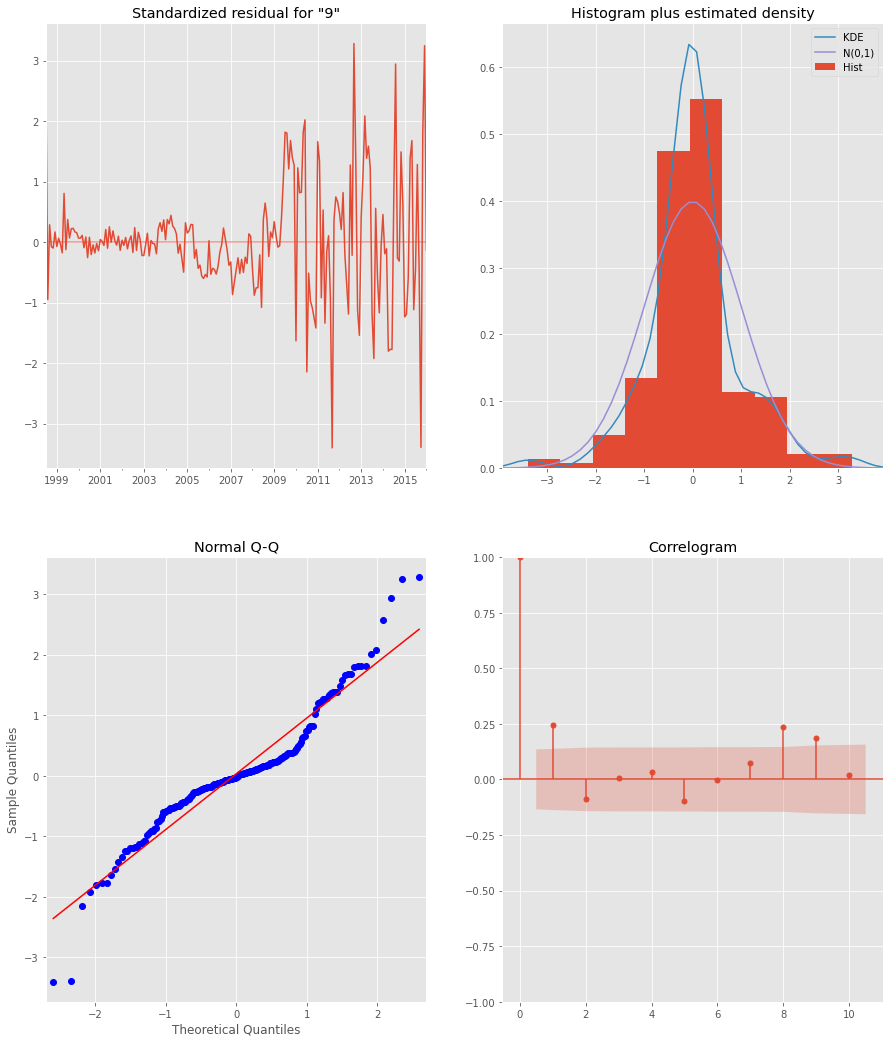

The Root Mean Squared Error of our forecasts is 58117.0


['94590']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9712      0.016     61.356      0.000       0.940       1.002
ma.L1          0.5069      0.039     13.013      0.000       0.431       0.583
ar.S.L12       0.1627      0.032      5.014      0.000       0.099       0.226
ma.S.L12      -0.8593      0.046    -18.616      0.000      -0.950      -0.769
sigma2      4.474e+05   3.39e+04     13.214      0.000    3.81e+05    5.14e+05


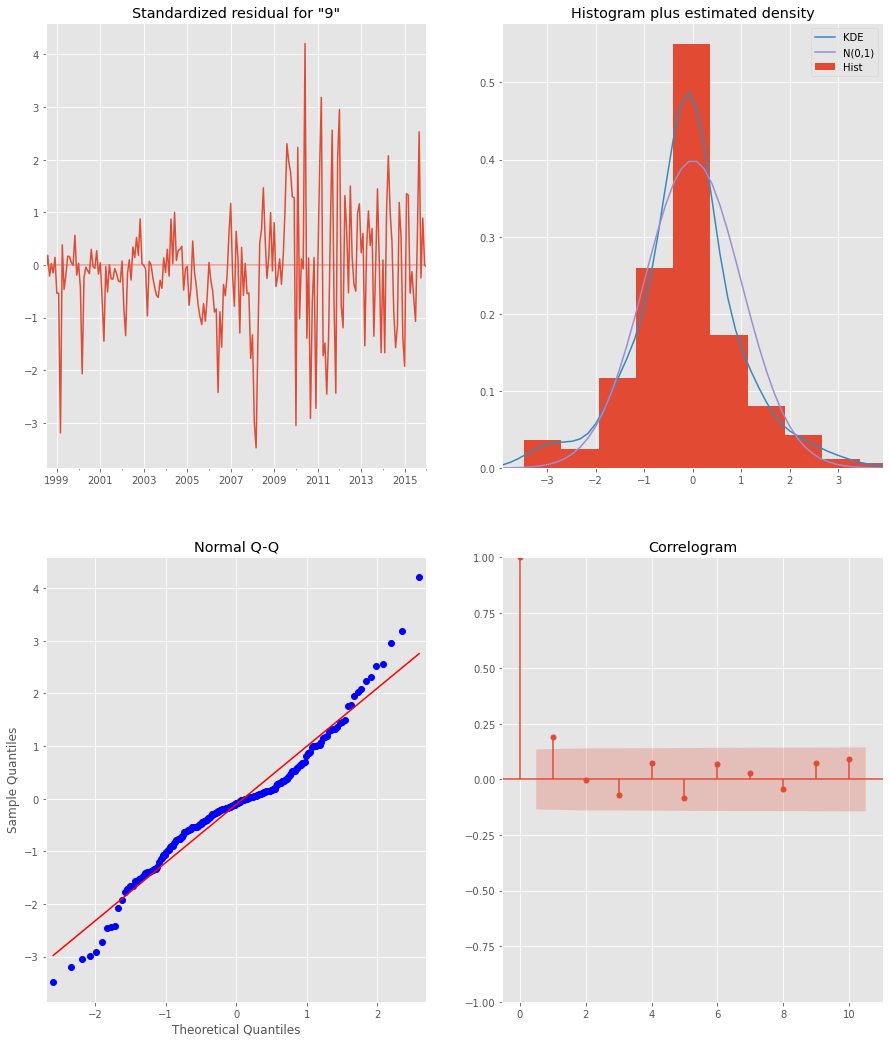

The Root Mean Squared Error of our forecasts is 9986.0


['33460']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9778      0.014     68.825      0.000       0.950       1.006
ma.L1          0.5459      0.024     22.808      0.000       0.499       0.593
ar.S.L12      -0.6195      0.063     -9.809      0.000      -0.743      -0.496
ma.S.L12      19.6087     27.280      0.719      0.472     -33.859      73.076
sigma2       403.6864   1126.099      0.358      0.720   -1803.427    2610.799


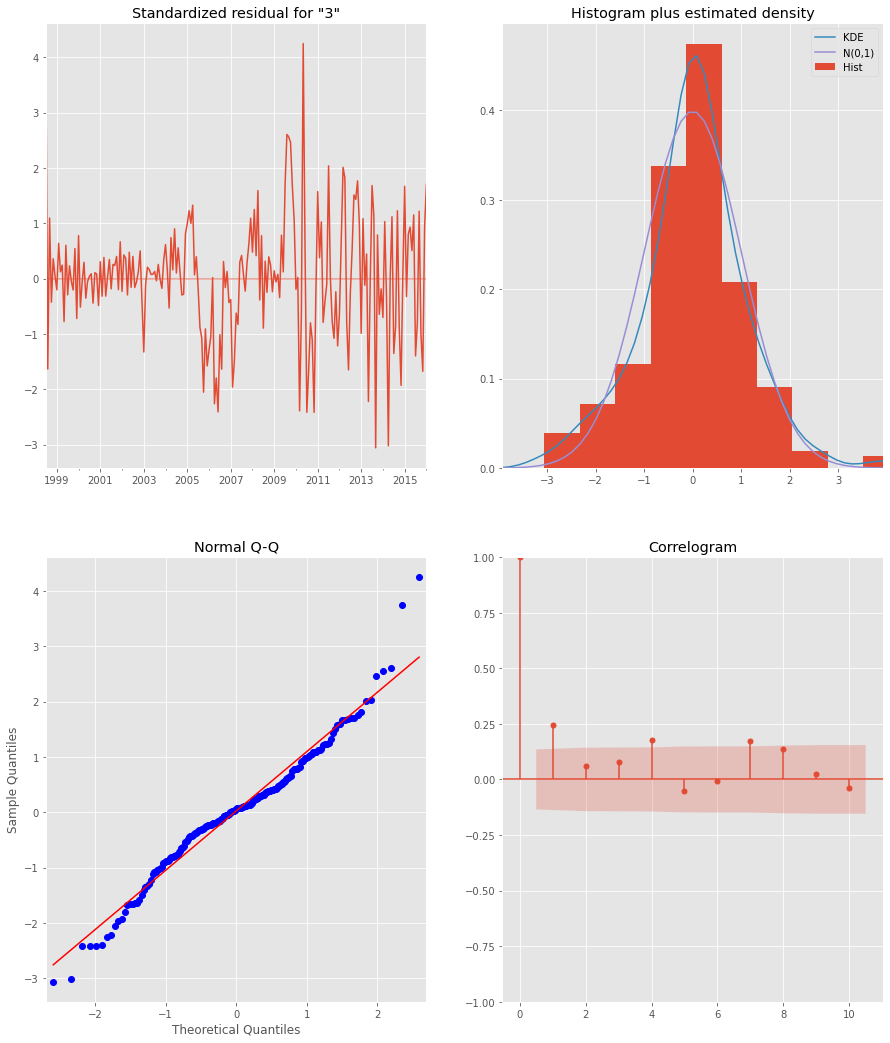

The Root Mean Squared Error of our forecasts is 2775.0


['94606']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8734      0.034     25.839      0.000       0.807       0.940
ma.L1          0.6692      0.047     14.135      0.000       0.576       0.762
ar.S.L12       0.2098      0.083      2.515      0.012       0.046       0.373
ma.S.L12      -0.5293      0.066     -8.053      0.000      -0.658      -0.400
sigma2      2.408e+06   2.24e+05     10.770      0.000    1.97e+06    2.85e+06


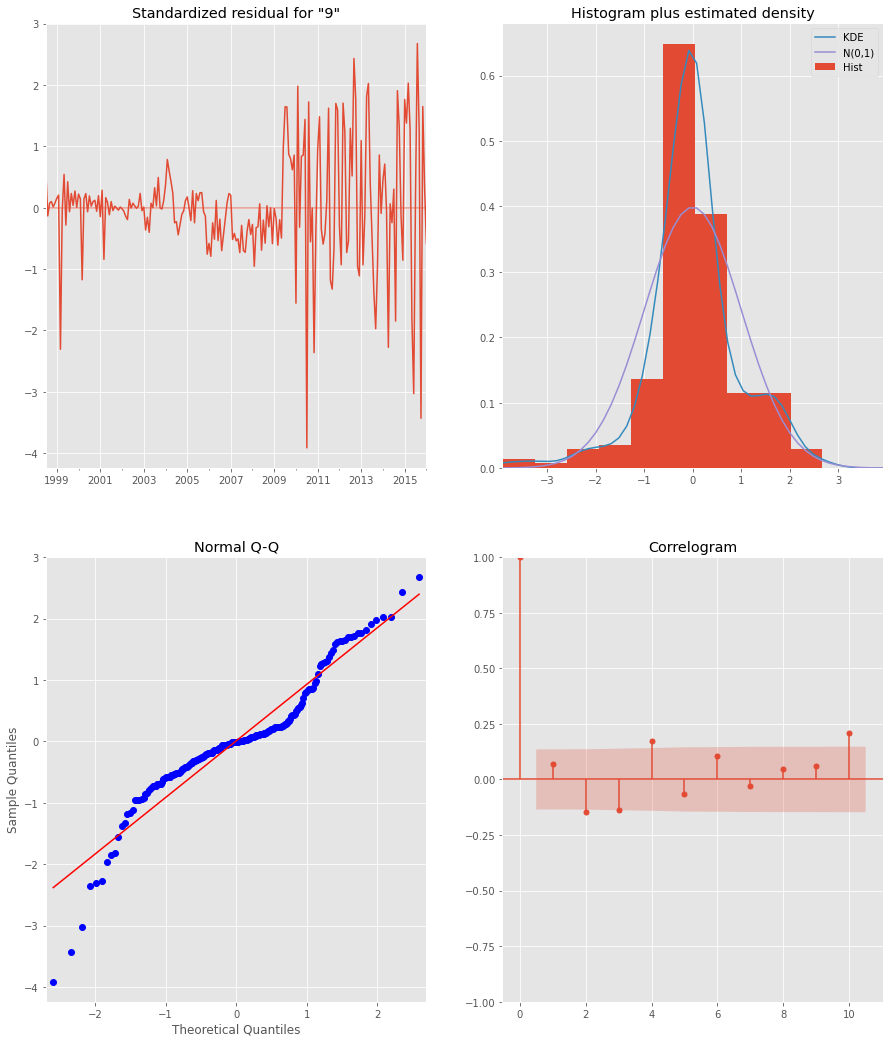

The Root Mean Squared Error of our forecasts is 20071.0


['94804']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9260      0.038     24.364      0.000       0.852       1.001
ma.L1          1.1079      0.040     27.458      0.000       1.029       1.187
ar.S.L12       0.1276      0.028      4.592      0.000       0.073       0.182
ma.S.L12      -0.2794      0.074     -3.784      0.000      -0.424      -0.135
sigma2      2.364e+06   3.69e+05      6.404      0.000    1.64e+06    3.09e+06


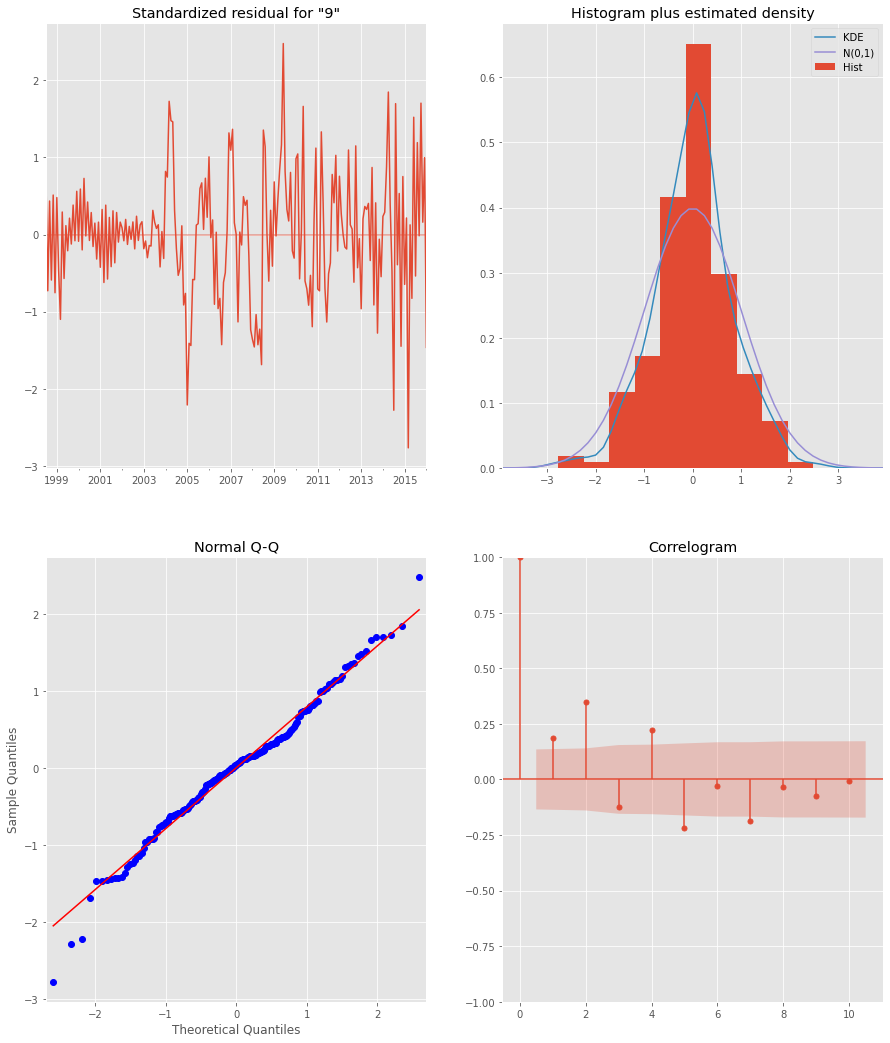

The Root Mean Squared Error of our forecasts is 44237.0


['89104']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9780      0.013     74.511      0.000       0.952       1.004
ma.L1          0.2738      0.037      7.446      0.000       0.202       0.346
ar.S.L12      -0.5424      0.040    -13.727      0.000      -0.620      -0.465
ma.S.L12      16.2301      8.367      1.940      0.052      -0.170      32.630
sigma2       903.7866    935.906      0.966      0.334    -930.555    2738.128


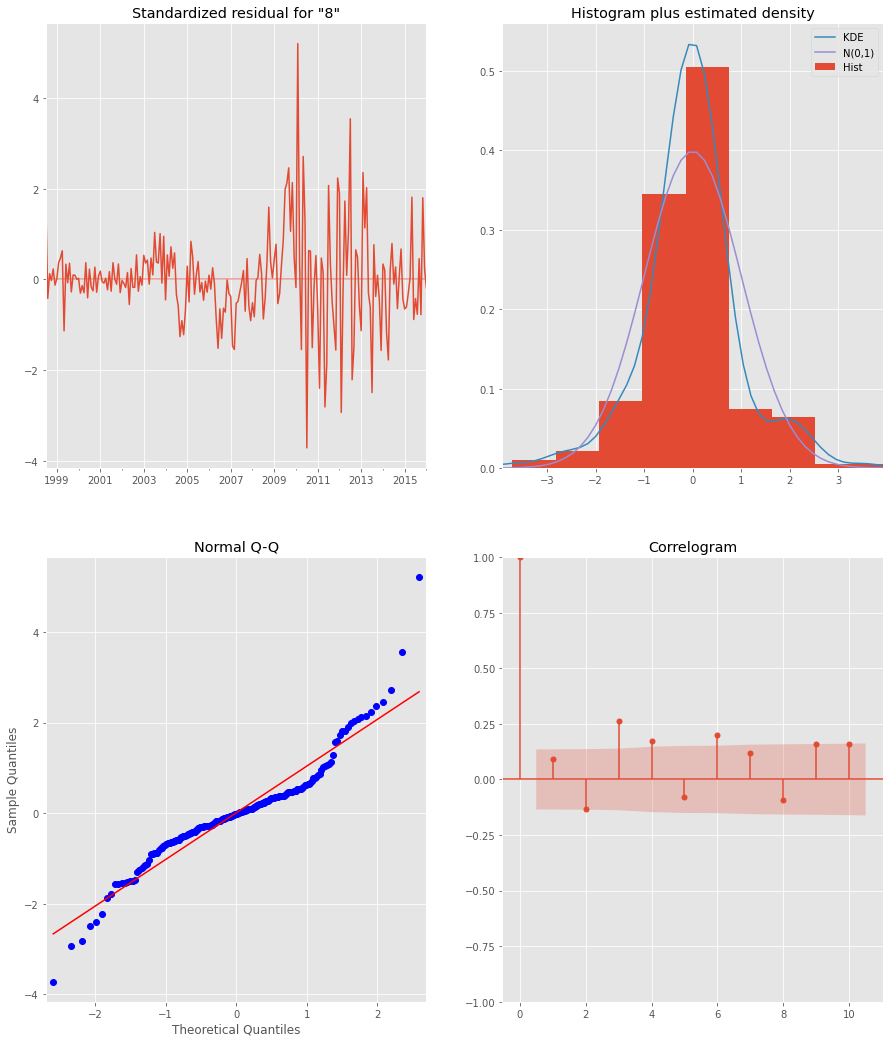

The Root Mean Squared Error of our forecasts is 12709.0


['85008']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9468      0.023     41.557      0.000       0.902       0.991
ma.L1          0.5435      0.039     14.114      0.000       0.468       0.619
ar.S.L12       0.0930      0.038      2.423      0.015       0.018       0.168
ma.S.L12      -0.9883      0.411     -2.403      0.016      -1.794      -0.182
sigma2      2.325e+05   9.64e+04      2.412      0.016    4.35e+04    4.21e+05


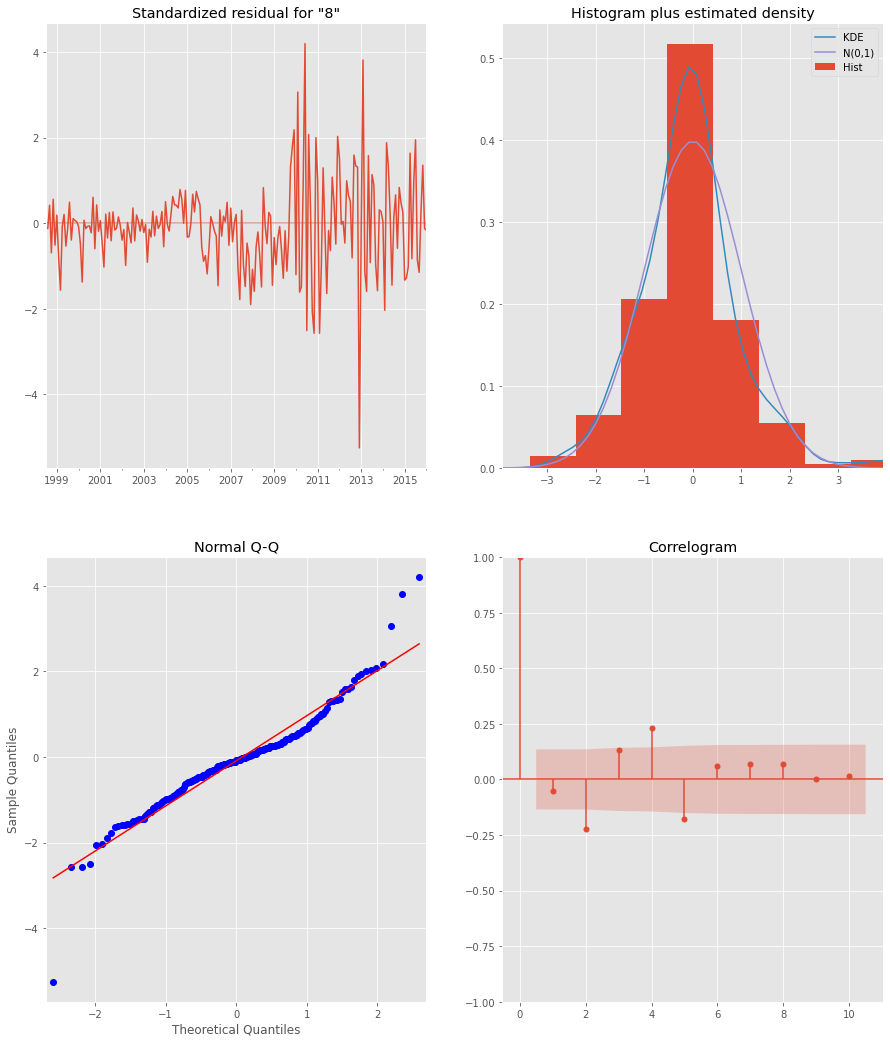

The Root Mean Squared Error of our forecasts is 12072.0


['95824']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9656      0.012     82.031      0.000       0.943       0.989
ma.L1          0.6079      0.040     15.376      0.000       0.530       0.685
ar.S.L12       0.1057      0.030      3.530      0.000       0.047       0.164
ma.S.L12      -0.9670      0.112     -8.656      0.000      -1.186      -0.748
sigma2      2.552e+05   3.45e+04      7.398      0.000    1.88e+05    3.23e+05


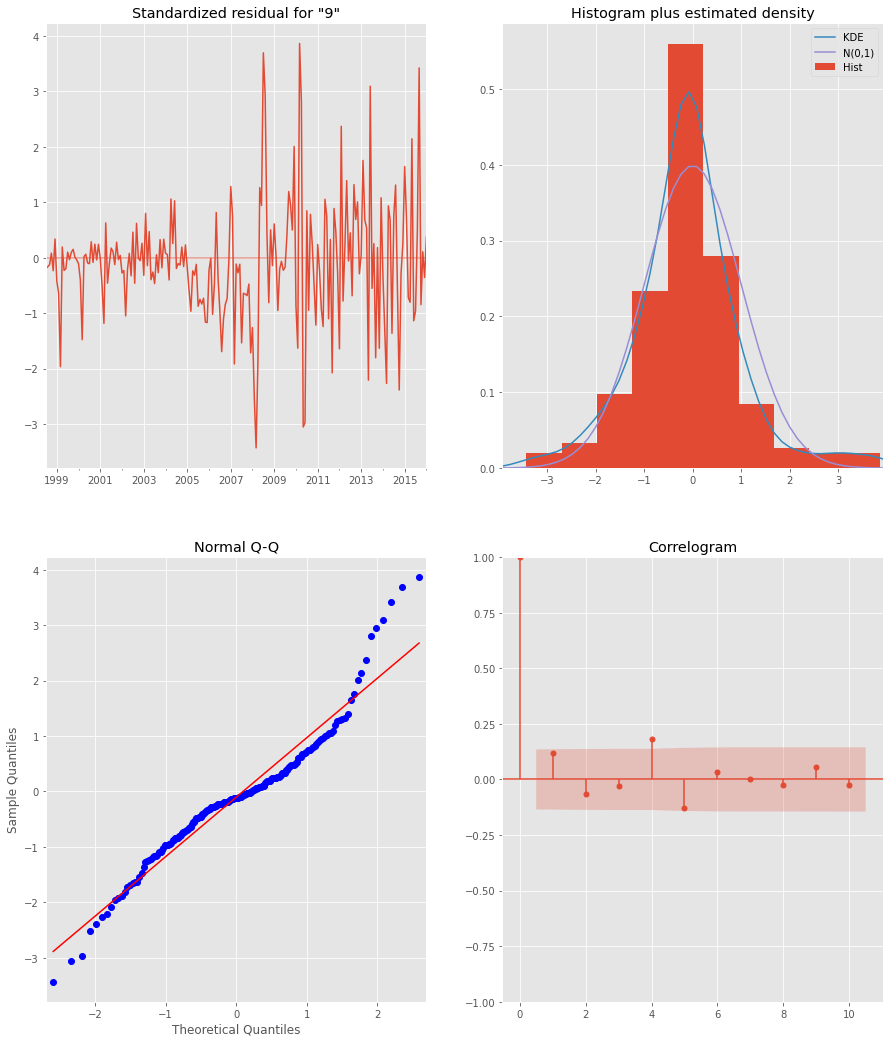

The Root Mean Squared Error of our forecasts is 5100.0


['33404']
(1, 1, 1) (0, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9743      0.015     65.986      0.000       0.945       1.003
ma.L1          0.5756      0.045     12.882      0.000       0.488       0.663
ma.S.L12      -0.9976      1.736     -0.575      0.566      -4.401       2.406
sigma2      8.182e+04    1.4e+05      0.583      0.560   -1.93e+05    3.57e+05


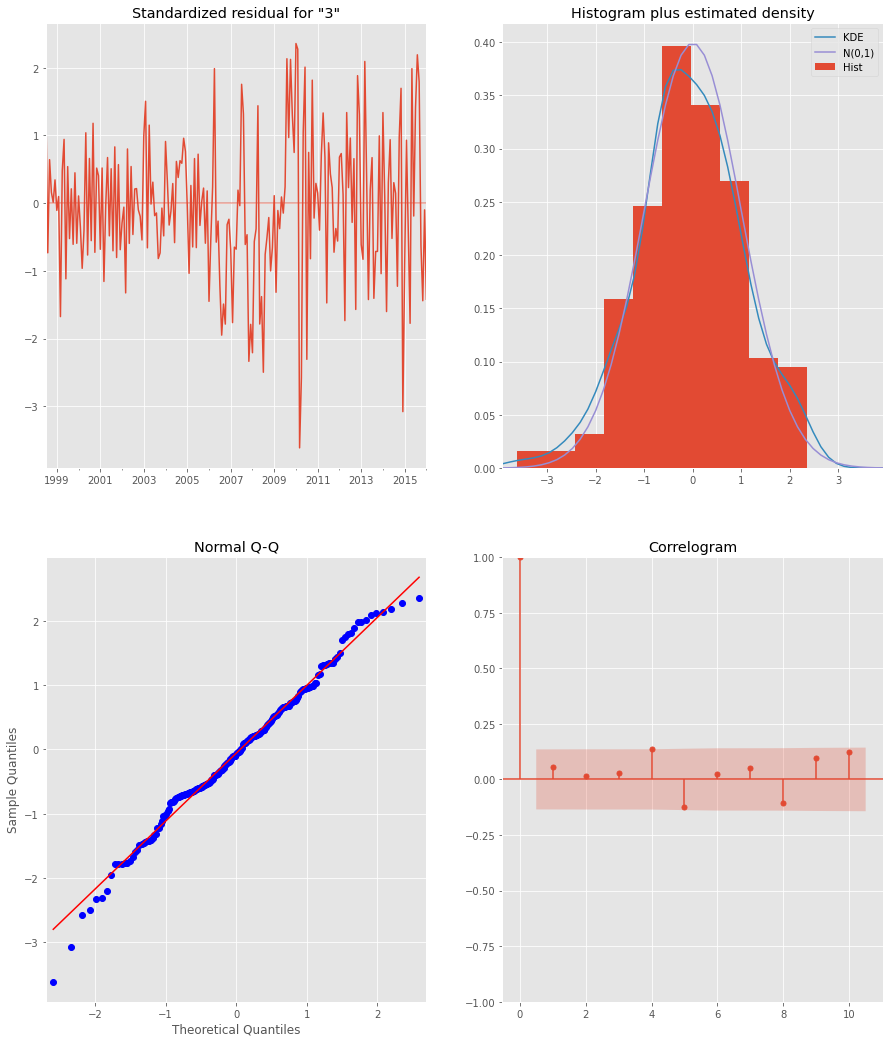

The Root Mean Squared Error of our forecasts is 20612.0


['33705']
(1, 1, 1) (0, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9582      0.020     48.155      0.000       0.919       0.997
ma.L1          0.5818      0.035     16.674      0.000       0.513       0.650
ma.S.L12      -0.9439      0.065    -14.448      0.000      -1.072      -0.816
sigma2      1.483e+05   1.21e+04     12.218      0.000    1.25e+05    1.72e+05


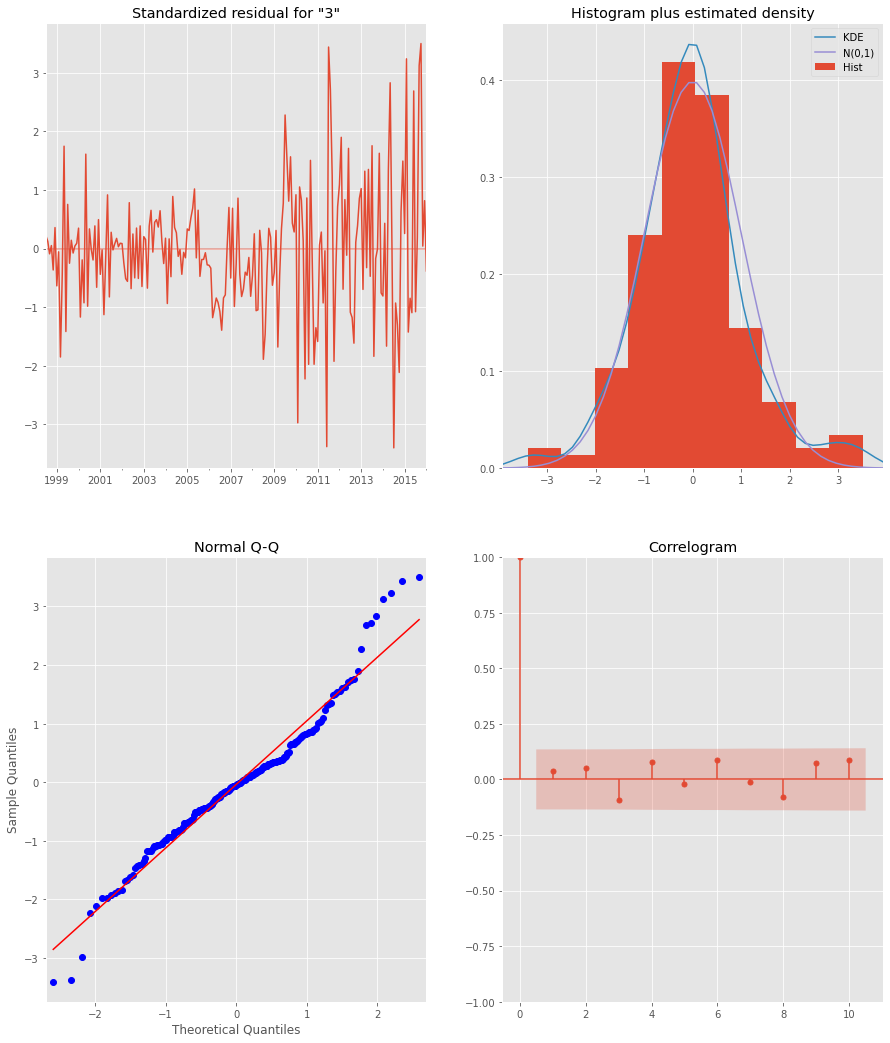

The Root Mean Squared Error of our forecasts is 19611.0


['89107']
(1, 1, 1) (0, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9414      0.020     47.806      0.000       0.903       0.980
ma.L1          0.6926      0.047     14.810      0.000       0.601       0.784
ma.S.L12      32.9930     60.954      0.541      0.588     -86.474     152.460
sigma2       219.4013    820.043      0.268      0.789   -1387.853    1826.655


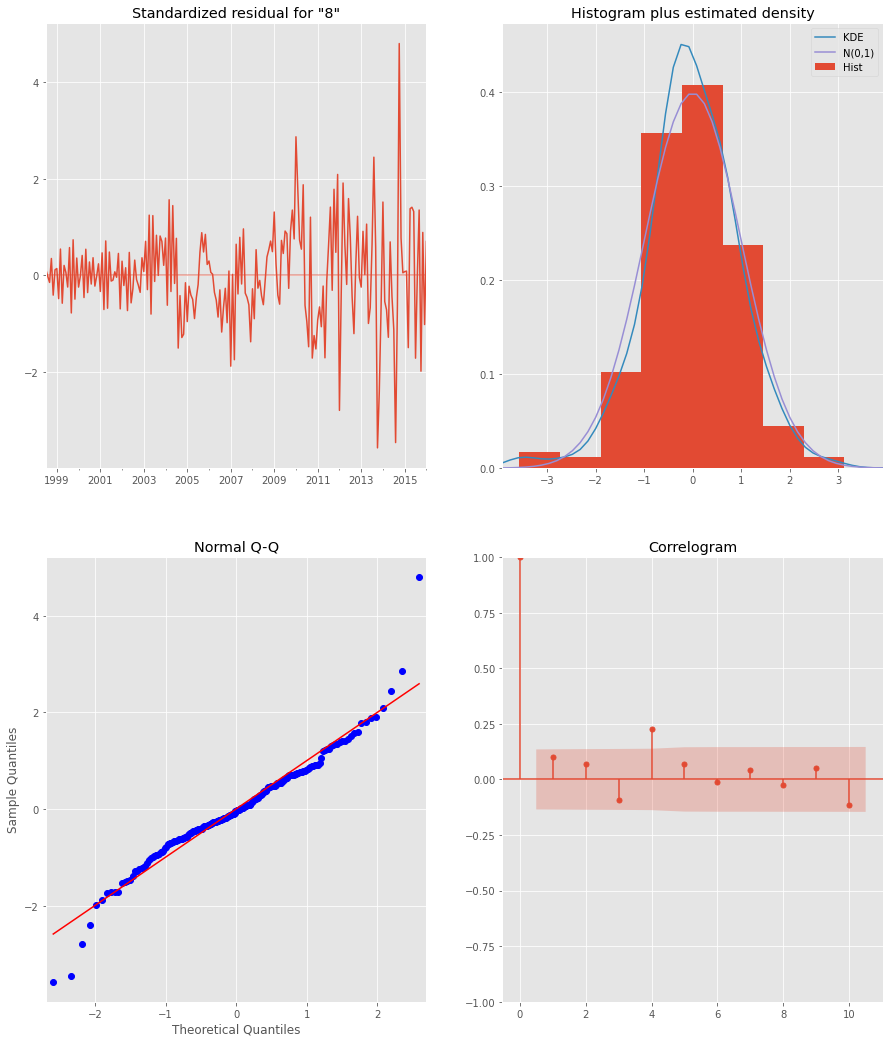

The Root Mean Squared Error of our forecasts is 5250.0


['89115']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9762      0.012     78.954      0.000       0.952       1.000
ma.L1          0.3515      0.019     18.566      0.000       0.314       0.389
ar.S.L12      -0.4913      0.065     -7.536      0.000      -0.619      -0.364
ma.S.L12      19.4042     17.505      1.108      0.268     -14.905      53.714
sigma2       445.5423    807.393      0.552      0.581   -1136.920    2028.004


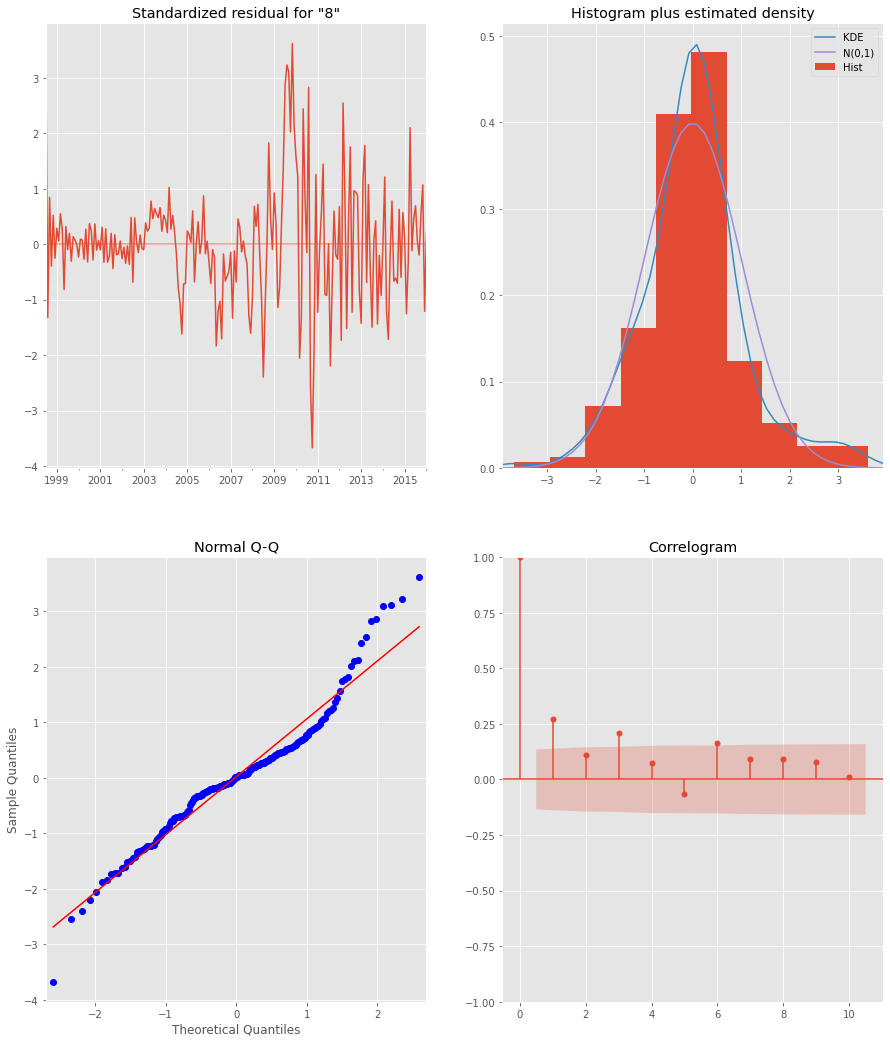

The Root Mean Squared Error of our forecasts is 3654.0


['95820']
(1, 1, 1) (1, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9642      0.017     55.430      0.000       0.930       0.998
ma.L1          0.4264      0.019     22.201      0.000       0.389       0.464
ar.S.L12      -0.5107      0.073     -6.988      0.000      -0.654      -0.367
ma.S.L12      21.1874     38.151      0.555      0.579     -53.588      95.963
sigma2       650.8028   2366.818      0.275      0.783   -3988.075    5289.681


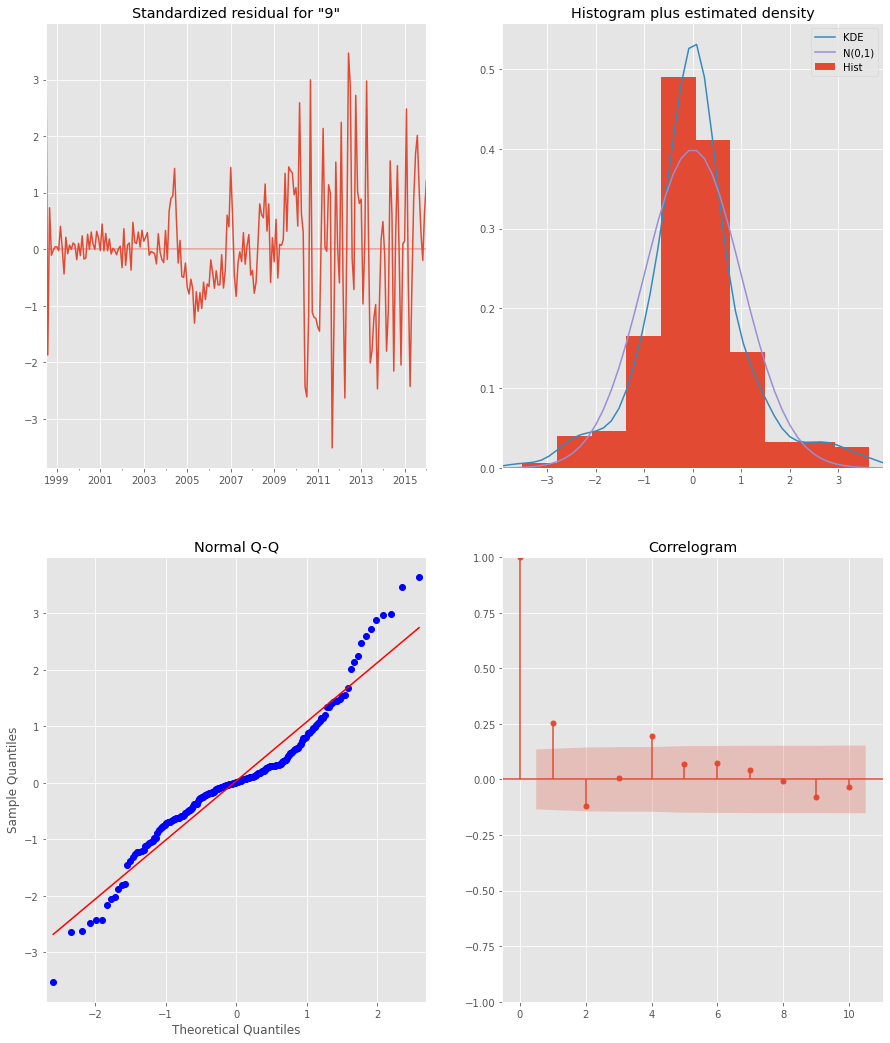

The Root Mean Squared Error of our forecasts is 19365.0


['48240']
(1, 1, 1) (0, 1, 1, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9596      0.021     45.757      0.000       0.918       1.001
ma.L1          0.4983      0.053      9.352      0.000       0.394       0.603
ma.S.L12      -0.9980      1.989     -0.502      0.616      -4.896       2.900
sigma2      4.774e+04   9.38e+04      0.509      0.611   -1.36e+05    2.31e+05


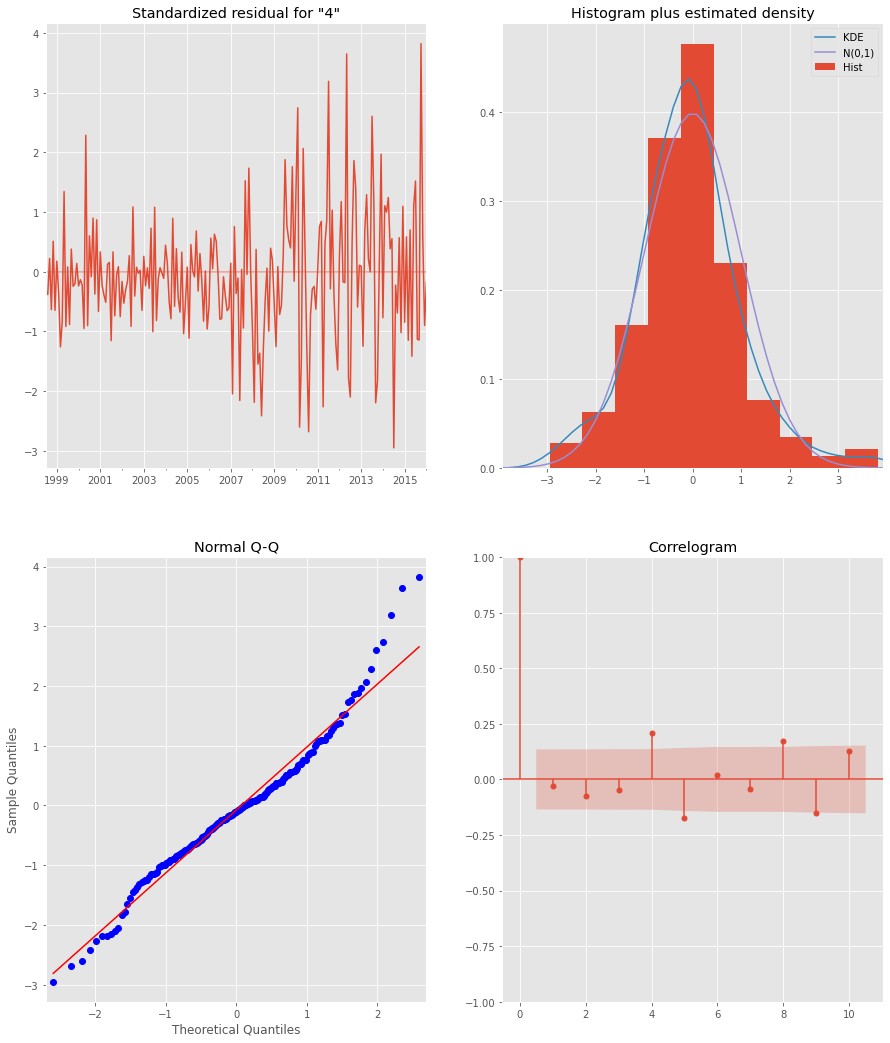

The Root Mean Squared Error of our forecasts is 2626.0


[58117.0, 9986.0, 2775.0, 20071.0, 44237.0, 12709.0, 12072.0, 5100.0, 20612.0, 19611.0, 5250.0, 3654.0, 19365.0, 2626.0]


In [28]:
# Create list to add rmse values during iteration
rmse_list = []



# iterate over prospects to extract optimal SARIMA values,
# instantiate SARIMAX model, make predictions
# and calculate the RMSE for each zip code
for zipcode in prospects['ZipCode']:
    zips = prospects.loc[prospects['ZipCode'] == zipcode]
    m1 = melt_data(zips)
    m1[str(zipcode)] = m1['value']
    m1 = m1.drop('value', axis=1)
    
    # create train and test sets
    train = m1.iloc[:238]
    test = m1.iloc[238:]
    
    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    outputs = []
    comb_list = []
    combs_list = []

    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                outputs.append([output.aic])
                comb_list.append([comb])
                combs_list.append([combs])
                AIC_df = pd.DataFrame(list(zip(outputs, comb_list, combs_list)))
                #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue

    # Print the lowest AIC and it's parameters for SARIMA
    AIC_df[0] = AIC_df[0].str.get(0)
    best_AIC = AIC_df.copy()
    lowest_AIC = min(best_AIC[0])
    lowest_AIC_row = AIC_df.loc[AIC_df[0] == lowest_AIC]
    #print(lowest_AIC_row)

    # call value for comb and combs for model input
    lowest_AIC_row[1] = lowest_AIC_row[1].str.get(0)
    lowest_AIC_row[2] = lowest_AIC_row[2].str.get(0)
    arima = lowest_AIC_row.iat[0,1]
    s = lowest_AIC_row.iat[0,2]
    print(str(m1.columns.values))
    print(arima, s)
    
    # Plug the optimal parameter values into a new SARIMAX model
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                                            order=arima, 
                                            seasonal_order=s, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    print(output.summary().tables[1])
    
    # Call plot_diagnostics() on the results calculated above 
    output.plot_diagnostics(figsize=(15, 18))
    plt.show()
    
    # Get actual results in dataframe
    price_truth = test['2016-02-01':]

    # Get predictions and forecast in dataframe
    prediction = output.get_forecast(steps=27)
    pred = prediction.predicted_mean
    forecast_result = output.get_forecast(steps=75)
    forecast = forecast_result.predicted_mean
    
    # Get confidence intervals of forecasts
    pred_conf = forecast.conf_int()

    # Get the real and predicted values
    prediction = pred[0:]
    price_truth = price_truth[str(zipcode)]

    # Compute the mean square error
    mse = ((prediction - price_truth) ** 2).mean()
    rmse = round(np.sqrt(mse))
    rmse_list.append(rmse)
    print('The Root Mean Squared Error of our forecasts is {}'.format(
        round(rmse, 2)))
    print()
    print()
    
# Print list of RMSE
print(rmse_list)

In [29]:
rmse_list

[58117.0,
 9986.0,
 2775.0,
 20071.0,
 44237.0,
 12709.0,
 12072.0,
 5100.0,
 20612.0,
 19611.0,
 5250.0,
 3654.0,
 19365.0,
 2626.0]

In [67]:
prospects['RMSE'] = rmse_list
prospects['RMSE_Ratio'] = prospects['RMSE']/prospects['2018-04']
#top_prospects = prospects.loc[[33460,94606,4298,815,5830]]
prospects

ZipCode              City State                  Metro    CountyName  \
1477    94601           Oakland    CA          San Francisco       Alameda   
1239    94590           Vallejo    CA                Vallejo        Solano   
2627    33460        Lake Worth    FL  Miami-Fort Lauderdale    Palm Beach   
1681    94606           Oakland    CA          San Francisco       Alameda   
1853    94804          Richmond    CA          San Francisco  Contra Costa   
1960    89104         Las Vegas    NV              Las Vegas         Clark   
474     85008           Phoenix    AZ                Phoenix      Maricopa   
4298    95824        Sacramento    CA             Sacramento    Sacramento   
2409    33404     Riviera Beach    FL  Miami-Fort Lauderdale    Palm Beach   
2661    33705  Saint Petersburg    FL                  Tampa      Pinellas   
2934    89107         Las Vegas    NV              Las Vegas         Clark   
815     89115         Las Vegas    NV              Las Vegas         Clark   
2775    95820        Sacramento    CA             Sacramento    Sacramento   
5830    48240           Redford    MI                Detroit         Wayne   

      SizeRank   1996-04   1996-05   1996-06   1996-07  ...  2017-09  2017-10  \
1477      1478  114600.0  114500.0  114500.0  114400.0  ...   514100   521100   
1239      1240  108200.0  107800.0  107500.0  107300.0  ...   343500   346700   
2627      2628   59800.0   59900.0   60000.0   60200.0  ...   198400   200400   
1681      1682  120400.0  120300.0  120300.0  120200.0  ...   622300   632800   
1853      1854  171300.0  170300.0  169400.0  168500.0  ...   438900   441700   
1960      1961   94800.0   94700.0   94700.0   94700.0  ...   184600   188500   
474        475   61600.0   61900.0   62200.0   62600.0  ...   206700   209200   
4298      4299   73800.0   73400.0   73000.0   72600.0  ...   213300   214500   
2409      2410   56800.0   56700.0   56600.0   56500.0  ...   124600   125900   
2661      2662   54600.0   54800.0   55000.0   55200.0  ...   158900   162500   
2934      2935   92300.0   92400.0   92500.0   92600.0  ...   175000   178000   
815        816   92500.0   92500.0   92600.0   92600.0  ...   160900   164000   
2775      2776   71800.0   71800.0   71800.0   71700.0  ...   254200   255000   
5830      5831   67800.0   68200.0   68500.0   68800.0  ...    68100    68700   

      2017-11  2017-12  2018-01  2018-02  2018-03  2018-04     RMSE  \
1477   526700   535800   546900   555000   562000   566700  58117.0   
1239   351200   357100   362500   366900   371600   376100   9986.0   
2627   202600   206000   209600   211600   213300   215600   2775.0   
1681   646100   663100   676500   683700   691700   696800  20071.0   
1853   443900   448000   452400   459200   471800   483100  44237.0   
1960   192500   196300   199500   202500   206000   208500  12709.0   
474    210200   210300   211300   213900   218800   223000  12072.0   
4298   215900   218400   221400   223500   224700   224700   5100.0   
2409   126900   128500   129900   130700   132300   134700  20612.0   
2661   165300   167100   168200   171100   175100   177300  19611.0   
2934   180700   184000   187000   190000   193500   196200   5250.0   
815    166300   168200   170400   172700   174700   176000   3654.0   
2775   256000   258000   260600   262300   263200   263200  19365.0   
5830    69700    71000    72300    73500    75300    76800   2626.0   

      RMSE_Ratio  
1477    0.102553  
1239    0.026551  
2627    0.012871  
1681    0.028805  
1853    0.091569  
1960    0.060954  
474     0.054135  
4298    0.022697  
2409    0.153022  
2661    0.110609  
2934    0.026758  
815     0.020761  
2775    0.073575  
5830    0.034193  

[14 rows x 273 columns]

In [69]:
#prospects.loc[[33460,94606,4298,815,5830]]

# Determine Price Forecast
* 5 year investment horizon

In [31]:
m1

48240
time               
1996-04-01  67800.0
1996-05-01  68200.0
1996-06-01  68500.0
1996-07-01  68800.0
1996-08-01  69200.0
...             ...
2017-12-01  71000.0
2018-01-01  72300.0
2018-02-01  73500.0
2018-03-01  75300.0
2018-04-01  76800.0

[265 rows x 1 columns]

In [53]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=75)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [54]:
prediction

In [55]:
#pred_conf

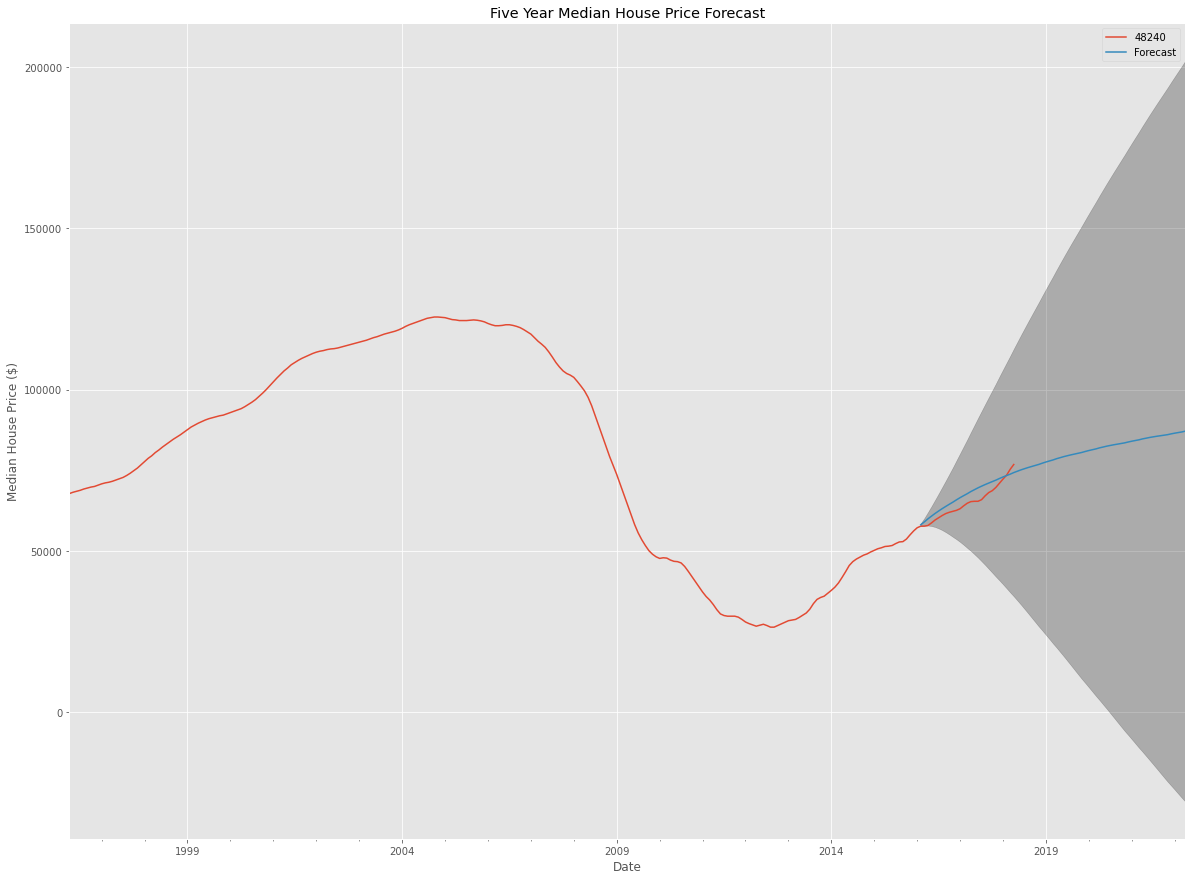

In [56]:
# Plot future predictions with confidence intervals
ax = m1.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median House Price ($)')
ax.set_title('Five Year Median House Price Forecast')

plt.legend()
plt.show()